# Homework 4

**Welcome** to our notebook. We know you're forced to review it but we hope you'll still enjoy the process :)

A small remark: the notebook seems huuuuuge (and you're getting anxious you'll have to read all of that) , but actually it isn't. It just contains loooots of visualizations

# Question 1
In this question we will explore the lalonde dataset. Here is a preview of the steps we will follow:
* First, we will explore the dataset, we will try to describe it, plot some graphs in order to get as much information as possible. We will check whether the treatment program is really "uniformly randomly assigned". For example, are white black and white people equally represented ?
* Then, after seeing it's not the case, we will use logistic regression in order to get the propensity scores for all the people and we will try to match people having same propensity scores. In this way the two groups should have equal distributions of the observed covariates. Doing our analysis on such a dataset will give us more precise results.
* In the end, we will realize that even this matching technique based on propensity scores is probably not yet optimal so we will try to do better: we will try to see which features are problematic (in the sense that on average they individually have a strong influence on the outcome) and to do the matching again but forcing those features to be the same for the two people in the match.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
import networkx as nx
from networkx.algorithms import bipartite

import seaborn as sns

%matplotlib inline

In [3]:
lalonde = pd.read_csv(r'lalonde.csv')
lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
# Check of undefined values
lalonde.isna().values.any()

False

In [5]:
# Set the id as the indexing column
lalonde.set_index("id", inplace=True)
# Small check to see if it really was unique and thus can be a valid index !
lalonde.index.duplicated().any()

False

In [6]:
# Avoid surprises later, check the types now :)
lalonde.dtypes

treat         int64
age           int64
educ          int64
black         int64
hispan        int64
married       int64
nodegree      int64
re74        float64
re75        float64
re78        float64
dtype: object

Let's merge all the race information in one column and define it in the following way:
- 0 for black
- 1 for hispan
- 2 for white

For this we'll use the following homemade formula.

In [46]:
lalonde["race"] = 2 - 2*lalonde.black - lalonde.hispan
lalonde = lalonde.drop(["black", "hispan"], axis=1)

In [47]:
lalonde.describe()

,treat,age,educ,married,nodegree,re74,re75,re78,race
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.415309,0.630293,4557.546569,2184.938207,6792.834483,1.091205
std,0.459198,9.881187,2.628325,0.493177,0.483119,6477.964479,3295.679043,7470.730792,0.935865
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,238.283425,0.000000
50%,0.000000,25.000000,11.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500,1.000000
75%,1.000000,32.000000,12.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500,2.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,2.000000


From these first statistiques, we already see a few things:
- All values are in the correct range
- only around 30% of the subjects are treated
- *age*: people referenced are quite young ! 
- *race*: most people are black

We'll now have a look at the two groups separately

In [48]:
# Let's define two views on our dataframe: one for treated and one for non-treated
lalonde_treat = lalonde[lalonde.treat == 1]
lalonde_notreat = lalonde[lalonde.treat == 0]

What can we say about the outcome (re78) ?

In [49]:
lalonde_treat.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [50]:
lalonde_notreat.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

The mean outcome for the non-treated group is slightly larger but the max salary for the other group is way larger (outliers) !

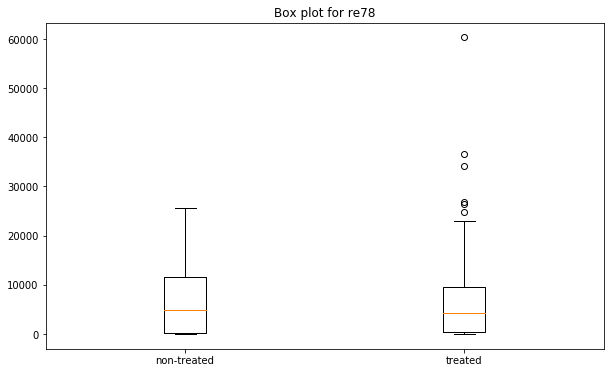

In [51]:
plt.figure(figsize=(10,6))
plt.title("Box plot for re78")
plt.boxplot((lalonde_notreat.re78.values, lalonde_treat.re78.values), labels=("non-treated", "treated"))

plt.show()

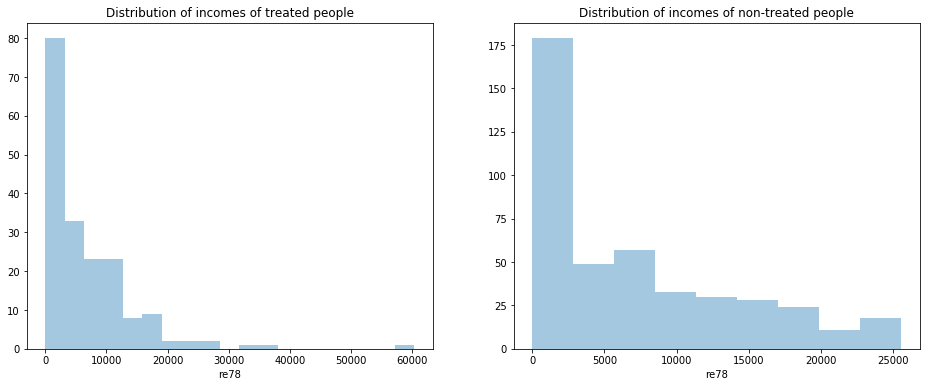

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_title("Distribution of incomes of treated people")
sns.distplot(lalonde_treat.re78, kde=False, ax=ax[0])

ax[1].set_title("Distribution of incomes of non-treated people")
sns.distplot(lalonde_notreat.re78, kde=False, ax=ax[1])
plt.show()

From now on we want to compare the features ideally on only one graph. Let's define a function that will plot the histograms of one feature for both groups and plot them on the same graph

In [53]:
def compare_hist(feature, title, no_treat_df=lalonde_notreat, treat_df=lalonde_treat, bins=None, fit=True, normed=True):
    plt.figure(figsize=(11,8))
    plt.title("Distribution of " + title)
    
    sns.distplot(no_treat_df[feature], label="no treat", bins=bins, kde=fit, norm_hist=normed)
    sns.distplot(treat_df[feature], label="treat", bins=bins, kde=fit, norm_hist=normed)

    plt.ylabel("Density" if normed else "Count")

    plt.legend(loc="upper right")
    plt.show()

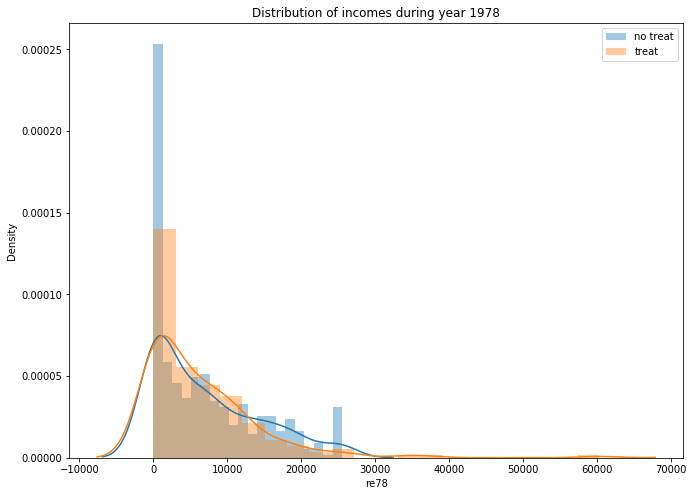

In [54]:
compare_hist("re78", "incomes during year 1978", bins=20)

The income of the non-treated people seems generally higher !

A naive researcher might conclude that the training has a negative influence on the salary of the people. Indeed, people who didn't get the training seem to have a higher salary in average (both the mean and the median are higher for the no-training group)

But we're not naive (hopefully) ^_^

## 2

Let's start by having a general overview of the treated group

In [55]:
lalonde_treat.describe()

,treat,age,educ,married,nodegree,re74,re75,re78,race
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.254054
std,0.0,7.155019,2.010650,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.621444
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.000000
50%,1.0,25.000000,11.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,0.000000
75%,1.0,29.000000,12.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,0.000000
max,1.0,48.000000,16.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,2.000000


Impressive, the median for re74 and re75 are 0 ! This group certainly contains younger people without a professional experience yet

In [56]:
lalonde_notreat.describe()

,treat,age,educ,married,nodegree,re74,re75,re78,race
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.512821,0.596737,5619.236506,2466.484443,6984.169742,1.452214
std,0.0,10.786653,2.855238,0.500419,0.491126,6788.750796,3291.996183,7294.161791,0.809220
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,220.181300,1.000000
50%,0.0,25.000000,11.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,2.000000
75%,0.0,35.000000,12.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,2.000000
max,0.0,55.000000,18.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,2.000000


We already see, amongst other information, that the mean age in the "no-treat" group is higher. This could imply that they have a greater professional experience. We also see the pre-treatment incomes which are much higher for the "no-treat" group. Let's visualize all that.

### RE74

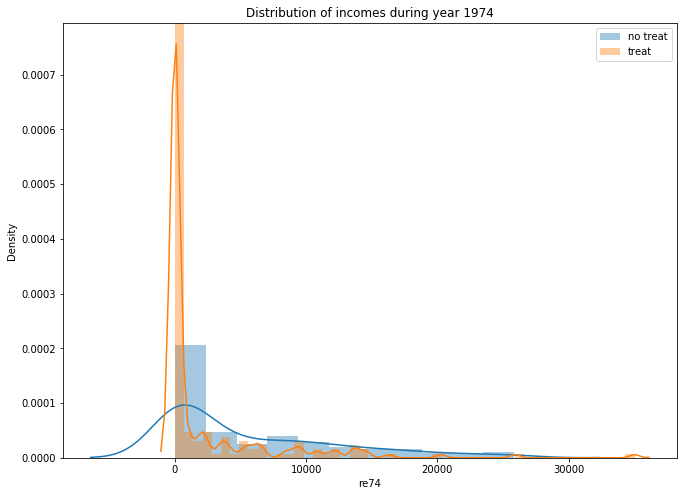

In [57]:
compare_hist("re74", "incomes during year 1974")

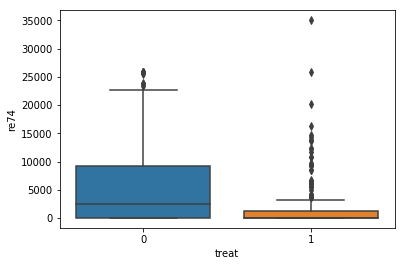

In [58]:
sns.boxplot(x="treat", y="re74", data=lalonde)

This confirms our assumption visually: basically people of the training group didn't earn much before the experiment (if we let aside the outliers). Maybe they're younger (be patient, we'll visalize that) or have longer educations.

### RE75

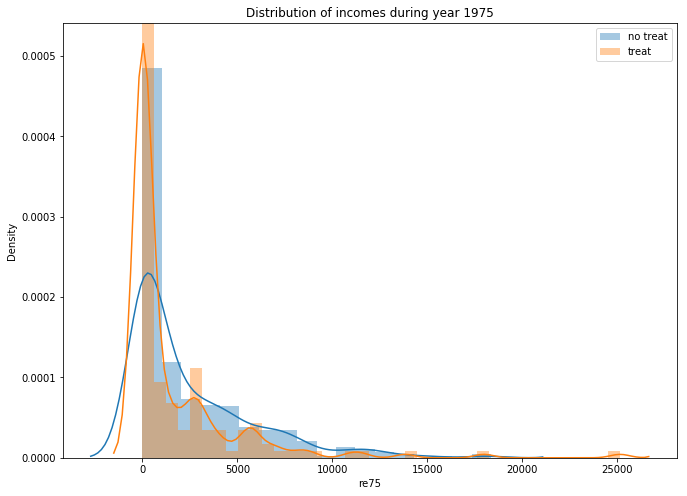

In [59]:
compare_hist("re75", "incomes during year 1975")

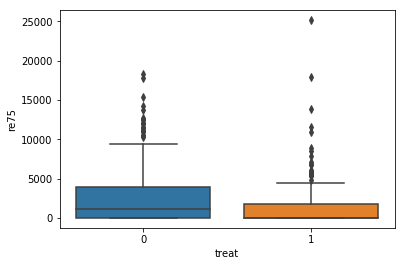

In [60]:
sns.boxplot(x="treat", y="re75", data=lalonde)

Same remarks as above.

The general remark to make is that people in the "no-treat" group already earned more than those of the other group pre-treatment. Then it's no surprise they earn more not long after the treatment.

### Age

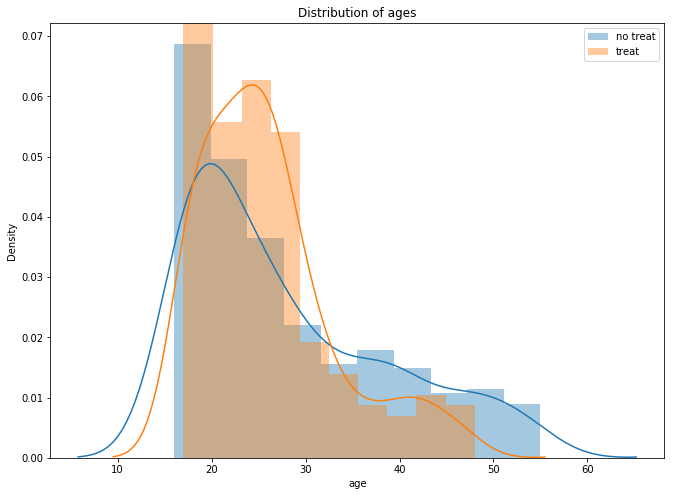

In [61]:
compare_hist("age", "ages")

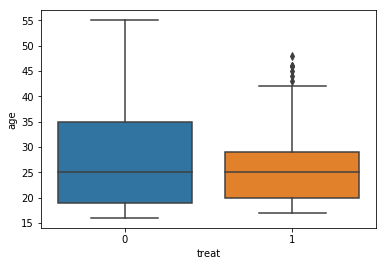

In [62]:
sns.boxplot(x="treat", y="age", data=lalonde)

Our assumption above is confirmed: treated people are much younger

### Duration of education

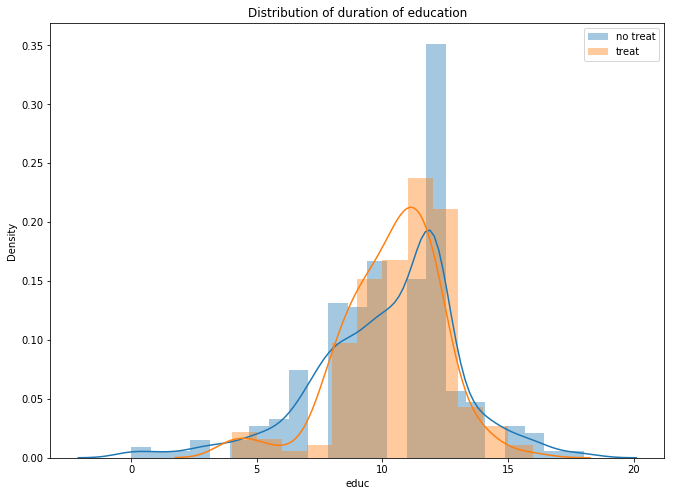

In [63]:
compare_hist("educ", "duration of education")

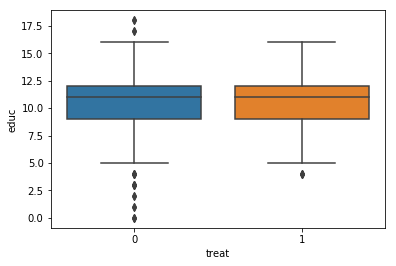

In [64]:
sns.boxplot(x="treat", y="educ", data=lalonde)

### Race

For the race we will plot the counts, and because the two groups don't contain the same amount of people, it doesn't make sense to plot them on the same graph. Our goal here is to visualize the proportion of people of each race for the two groups (treated and no-treated) and using two graphs is the best way to do it.

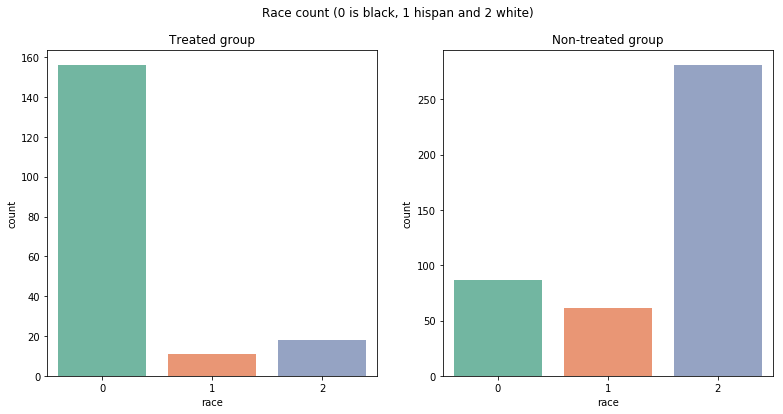

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(13,6))

plt.suptitle("Race count (0 is black, 1 hispan and 2 white)")
ax[0].set_title("Treated group")
sns.countplot(x="race", data=lalonde_treat, ax=ax[0], palette="Set2")

ax[1].set_title("Non-treated group")
sns.countplot(x="race", data=lalonde_notreat, ax=ax[1], palette="Set2")

Interesting ! We have a huge majority of black people in the treated group and mostly white people in the other ! Does this have an influence on the outcome ? Stay tuned :)

### Degree

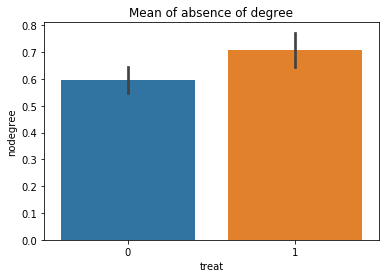

In [311]:
plt.title("Mean of absence of degree")
sns.barplot(x="treat", y="nodegree", data=lalonde)

More people in the treated group have no degree. Another cause of influence of the outcome ?

### Conclusion

Now we see that the values has nothing special to do with treat or no treat. Somehow we see that the selection was far from uniform at random. 

In the treat group there are more people with no degree than with degree. 
The "black" variable is interesting also. We usually associate, let's say a black neighborhood, to more difficult social conditions. 
We can also note that there is a three years difference in mean age between the two groups so, in a sense, we guess that people in the no treat group have more experience on average and this should imply the higher mean salary in the no treat group. 
We can also say that the age parameter has a lot of impact on the nodegree and the married parameters. Somehow, being 3 years older implies a higher probability of being married and a higher probability of having a degree.

Now we want to measure the propensity scores using logistic regression in order to be able to improve our analysis.

## 3

In [75]:
logistic = linear_model.LogisticRegression()
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# We won't include re78 since this is the salary after the subject is treated
features = ["age", "educ", "race", "married", "nodegree", "re74", "re75"]
X = scaler.fit_transform(lalonde[features])
#X = (lalonde[features] - lalonde[features].mean(axis=0))/lalonde[features].std(axis=0)
y = lalonde.treat

logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now let's take a look at the score:

In [76]:
logistic.score(X, y)

0.82410423452768733

This is a pretty nice score, we didn't even do features engineering to get there :)

In [80]:
# Let's appreciate the vision of some probability numbers
logistic.predict_proba(X)[::60]

array([[ 0.45051862,  0.54948138],
       [ 0.34472915,  0.65527085],
       [ 0.31503683,  0.68496317],
       [ 0.67776284,  0.32223716],
       [ 0.963959  ,  0.036041  ],
       [ 0.97293953,  0.02706047],
       [ 0.91668716,  0.08331284],
       [ 0.96328816,  0.03671184],
       [ 0.97923457,  0.02076543],
       [ 0.42028307,  0.57971693],
       [ 0.33630961,  0.66369039]])

While the score above is nice, it's not really informative, what we want here is the propensity score measure.

In [82]:
propensity = [b for [a,b] in logistic.predict_proba(X)]

Now we have our propensity scores for all "nodes"

In [83]:
propensity[::60]

[0.54948138118465639,
 0.65527084842816474,
 0.68496317420423636,
 0.32223715978328121,
 0.036040998608550125,
 0.027060465105700506,
 0.083312837460129435,
 0.036711841913761409,
 0.020765426363760969,
 0.57971692860895629,
 0.66369039049491341]

## 4

What we want now is to do matching : we would like to match each subject of the *treat* group with another one from the *non-treat* group having a close propensity score

Now we want to separate the dataset into the treat and no treat groups:

In [84]:
data_propensity = lalonde.copy()
data_propensity["propensity"] = propensity

data_treat_propensity = data_propensity[data_propensity.treat == 1]
data_no_treat_propensity = data_propensity[data_propensity.treat == 0]

Now let's go and create a bipartite graph. So our first strategy (we will find another one if this one doesn't work) is that the weight of the edge between the two nodes is the absolute difference in propensity scores between them. And then we will use networkx to find a min-weight matching

In [86]:
G = nx.Graph()

# The labels of the nodes will be their ID's
G.add_nodes_from(data_treat_propensity.index.values, bipartite=0)
G.add_nodes_from(data_no_treat_propensity.index.values, bipartite=1)

# We now add the edges to build the bipartite graph. Every "left" node will be connected to every "right" node. Only the weights will differ
for i, row_i in data_treat_propensity.iterrows():
    for j, row_j in data_no_treat_propensity.iterrows():
        # Since the method we use is based on max matching we use negative value to get min matching
        G.add_edge(i, j, weight = -abs(row_i["propensity"] - row_j["propensity"]))

We can also compute the min weight matching without max cardinality:

In [90]:
matching_propensity = nx.max_weight_matching(G)

# the matchings are duplicated (1 -> 2 and 2 -> 1), we will only keep the first pair
matching_propensity = {k:v for (k,v) in matching_propensity.items() if "NSW" in k}
len(matching_propensity)

10

But the problem, as we can see, is that we end up with too few datapoints in the end:

In [91]:
def observe_matching(matching, verbose):
    sum_differences = 0
    for (a, b) in matching.items():
        propensity_score_a = data_propensity.loc[a]["propensity"]
        propensity_score_b = data_propensity.loc[b]["propensity"]
        diff = abs(propensity_score_a - propensity_score_b)
        if verbose:
            print("Difference between {} and {} is {}".format(a, b, diff))
        sum_differences += diff
    print("Mean difference in prop score is {}".format(sum_differences / len(matching)))
    
observe_matching(matching_propensity, False)

Mean difference in prop score is 0.0


Here we see the problem with using min matching without max cardinality. The algorithm will compute the "real" min matching and it will only match the points with the same propensity scores for that. We will continue with the matchings we obtain by using max cardinality matchings:

In [92]:
matching_propensity_max_card = nx.max_weight_matching(G, maxcardinality=True)
# The matching are returned twice (in both directions), even when using a directed graph :O We filter the duplicates
matching_propensity_max_card = {k:v for (k,v) in matching_propensity_max_card.items() if "NSW" in k}
len(matching_propensity_max_card)

185

In [93]:
observe_matching(matching_propensity_max_card, False)

Mean difference in prop score is 0.1835283976092737


This matching takes into account all datapoints from the treat (the smallest) group. So it has 185 matchings. In general those matchings are pretty good, very similar points are matched with each other. But if we inspect the values we see that there are some "outliers" matchings since all points have to be matched.

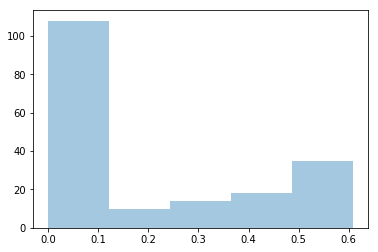

In [94]:
propensity_differences_matchings = list(map(lambda matching: (matching[0], abs(data_propensity.loc[matching[0]]["propensity"] - data_propensity.loc[matching[1]]["propensity"])), 
                                                   matching_propensity_max_card.items()))
propensity_differences_matchings = [prop for (index, prop) in propensity_differences_matchings]
sns.distplot(propensity_differences_matchings, kde=False)

Looking at this histogram we see that there are some bothering matchings where the differences in propensity scores are more than 0.5. A third alternative may be to apply a threshold after the matching to get rid of those values but let's already see how far we can go with our 185-matchings set

Now let's look at the re78 values for both groups but we will take into account only the matched datapoints

In [95]:
group_treat = [a for (a, b) in matching_propensity_max_card.items()]
group_no_treat = [b for (a, b) in matching_propensity_max_card.items()]

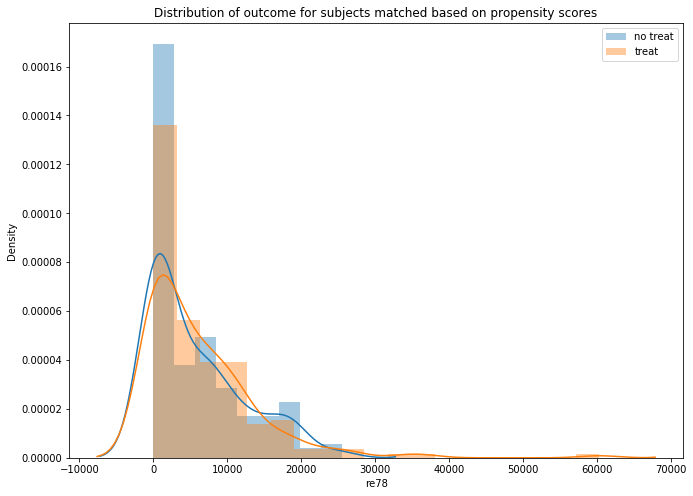

In [96]:
compare_hist("re78","outcome for subjects matched based on propensity scores", no_treat_df=lalonde.loc[group_no_treat], treat_df=lalonde.loc[group_treat])

So this is our distribution. Maybe we can argue we see things in a better way on this histogram. The number of samples is exactly the same for both groups (the number of samples in the treat group) and the two groups were obtained using the min matching method on the bipartite graph. Here we clearly see that the "extreme" outliers belong to the treat group. But however, there are not so many of them. We can also see that the first bin (the least salary) contains more people from the non treated than the treated group (however, if we look at the re78 column in out dataset we see that there are a lot of 0 values so either the dataset has errors or those people are simply unemployed). So the only thing we might try to guess from this is that the treat works well on a few people: the blue outliers. (but maybe those people anyway had more determination and this determination is what caused them to take the treat so the variable is something that we do not have in our dataset: the determination)

Now let's tweak things to see if we can get better insights. The first thing we want to try is to simply remove the matchings where the difference is too big. We will end up with much less datapoints but we might get something out of it:

In [97]:
def filter_matching(matching, threshold=0.4):
    def difference_matching(x, y):
        return abs(data_propensity.loc[x]["propensity"] - data_propensity.loc[y]["propensity"])

    matching_propensity_max_card_pairs = map(lambda x : (x[0], x[1], difference_matching(x[0], x[1])), matching.items())
    matching_propensity_max_card_pairs = filter(lambda x : x[2] <= threshold, matching_propensity_max_card_pairs)
    return list(matching_propensity_max_card_pairs)

def plot_matching_hist(matching, threshold=0.4):
    matchings = filter_matching(matching, threshold)
    group_treat = [a for (a, b, prop) in matchings]
    group_no_treat = [b for (a, b, prop) in matchings]
    compare_hist("re78","outcome for subjects matched based on propensity scores", no_treat_df=lalonde.loc[group_no_treat], treat_df=lalonde.loc[group_treat])

Let's see what we get with the threshold at 0.4:

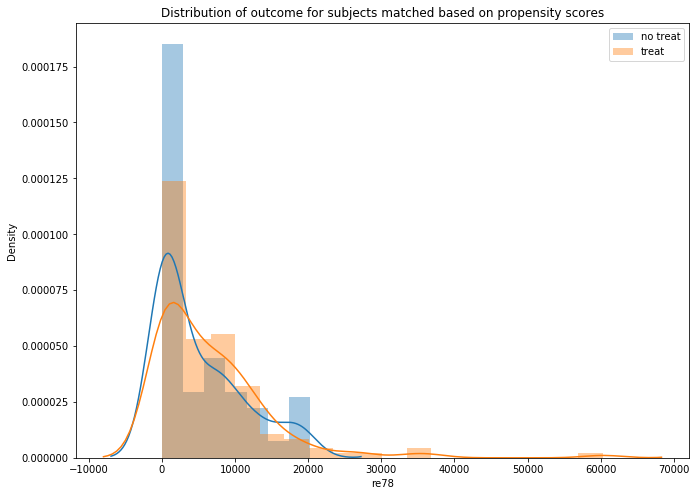

In [98]:
plot_matching_hist(matching_propensity_max_card, 0.4)

And at 0.2:

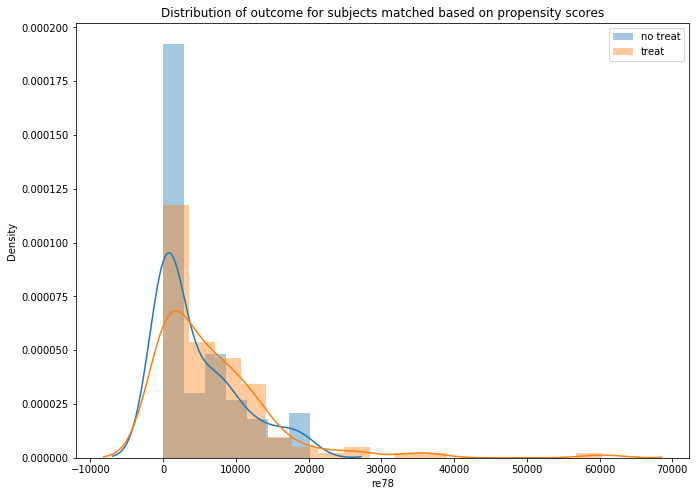

In [99]:
plot_matching_hist(matching_propensity_max_card, 0.2)

At 0.1 (very similar propensity scores):

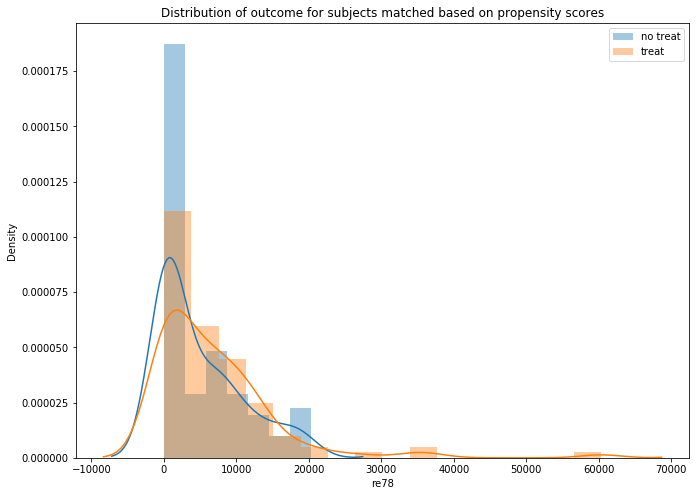

In [100]:
plot_matching_hist(matching_propensity_max_card, 0.1)

At 0.05 (very very similar propensity scores)

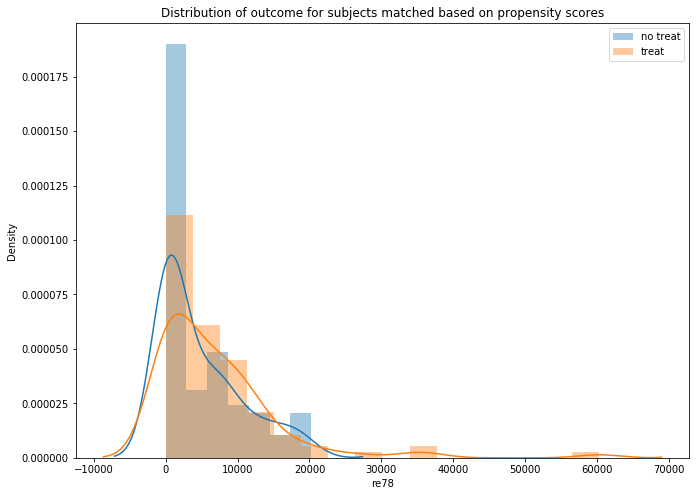

In [101]:
plot_matching_hist(matching_propensity_max_card, 0.05)

At 0 (Exactly the same propensity scores) :

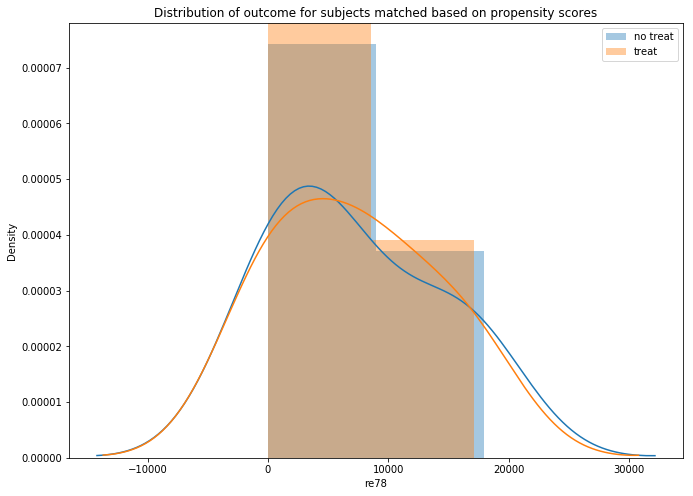

In [102]:
plot_matching_hist(matching_propensity_max_card, 0)

The general thing we always see no matter the threshold is that the treat group always has those outliers who have really big salaries (except in the threshold 0 case where they do not appear).

## 5

The general trend is somehow appearing: people in the no-treat group have a higher salary because they have more experience, are older and probably have better social conditions but there are a few outliers from the treat group. Let's try to redo our visualizations on the new data in order to see if there are some problematic variables.

In [103]:
group_treat = [a for (a, b) in matching_propensity_max_card.items()]
group_no_treat = [b for (a, b) in matching_propensity_max_card.items()]
lalonde_matched_treat = lalonde.loc[group_treat]
lalonde_matched_no_treat = lalonde.loc[group_no_treat]

lalonde_matched = pd.concat([lalonde_matched_treat, lalonde_matched_no_treat])

def compare_distributions(variable, action="matching", data1=lalonde, data2=lalonde_matched):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.suptitle("{} distributions before and after {}".format(variable, action))
    axes[0].set_title("{} distribution before {}".format(variable, action))
    axes[1].set_title("{} distribution after {}".format(variable, action))
    if variable in ["educ", "age", "re74", "re75", "re78"]:
        sns.boxplot(x="treat", y=variable, data=data1, ax=axes[0])
        sns.boxplot(x="treat", y=variable, data=data2, ax=axes[1])
    elif variable in ["nodegree", "married"]:
        sns.barplot(x="treat", y=variable, data=data1, ax=axes[0])
        sns.barplot(x="treat", y=variable, data=data2, ax=axes[1])
    elif variable in ["race"]:
        sns.countplot(x="race", hue="treat", data=data1, ax=axes[0])
        sns.countplot(x="race", hue="treat", data=data2, ax=axes[1])
    plt.show()

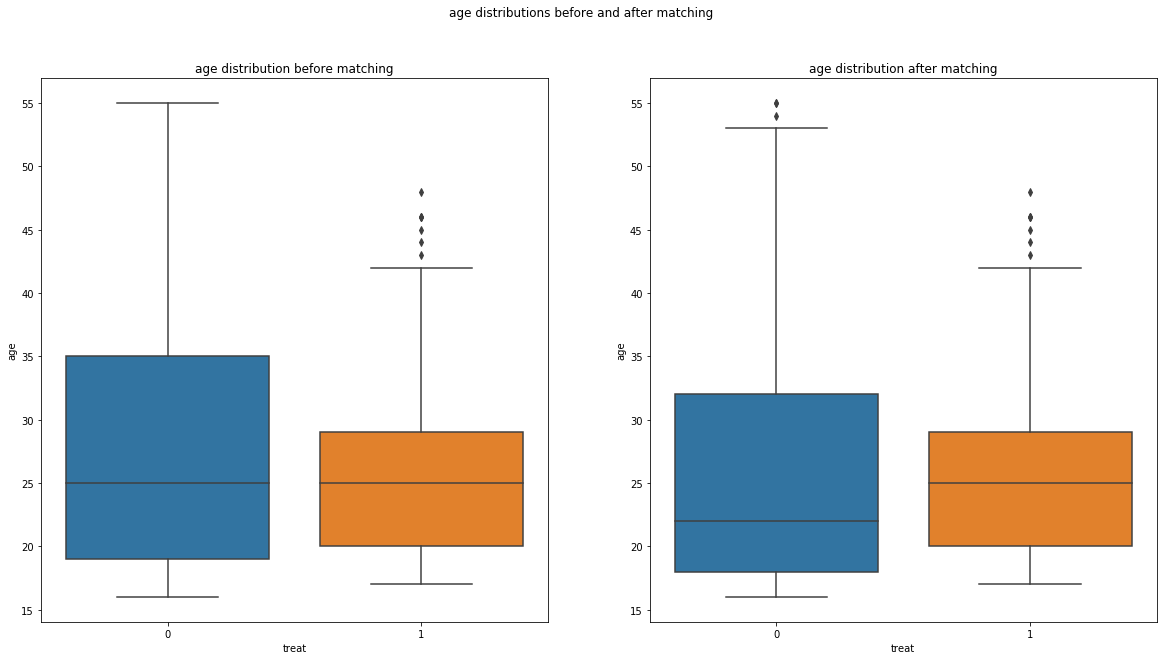

In [104]:
compare_distributions("age")

The age distribution seems a lot better, especially for the treat = 1 case. But we see that the two distributions are still a lot different !

Educ distributions after matching:

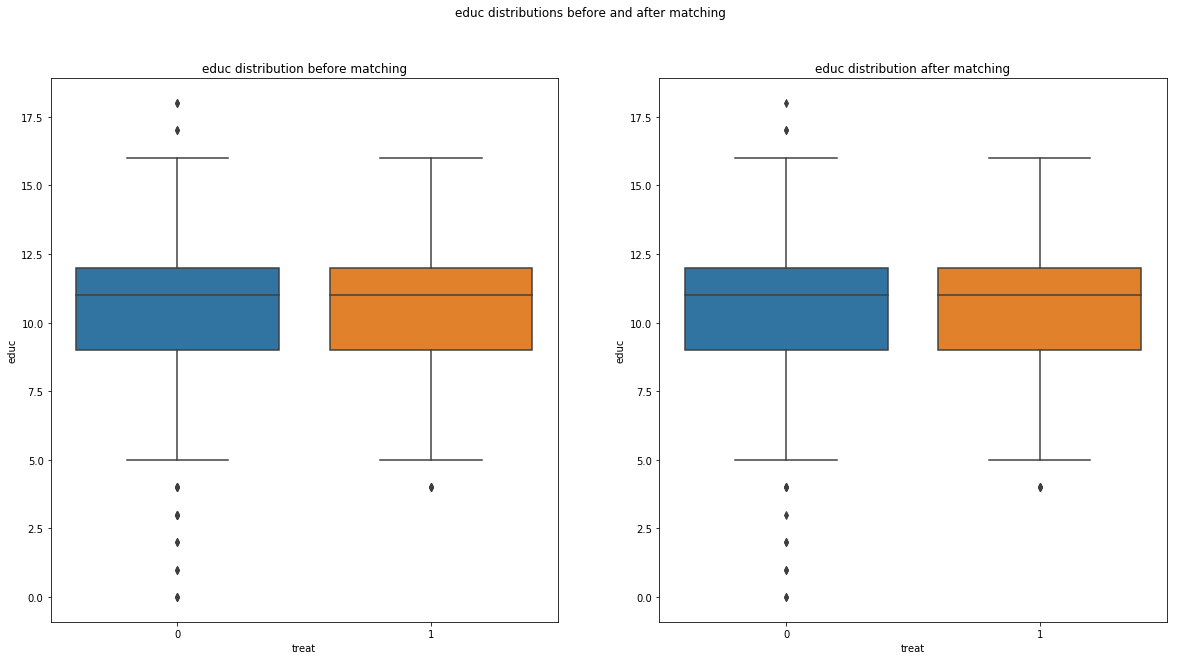

In [105]:
compare_distributions("educ")

Nothing to say about this. The educ distribution was already very good before the matching.

nodegree distributions after matching:

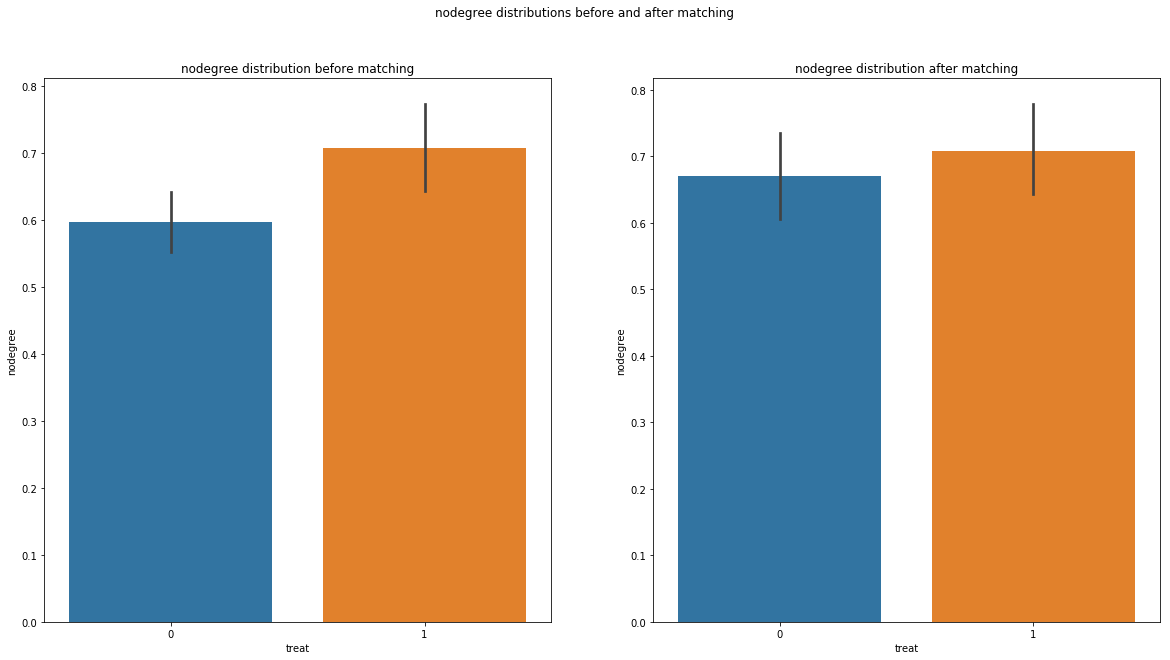

In [106]:
compare_distributions("nodegree")

The nodegree distribution seems to be much better after the matching than before !

married distributions:

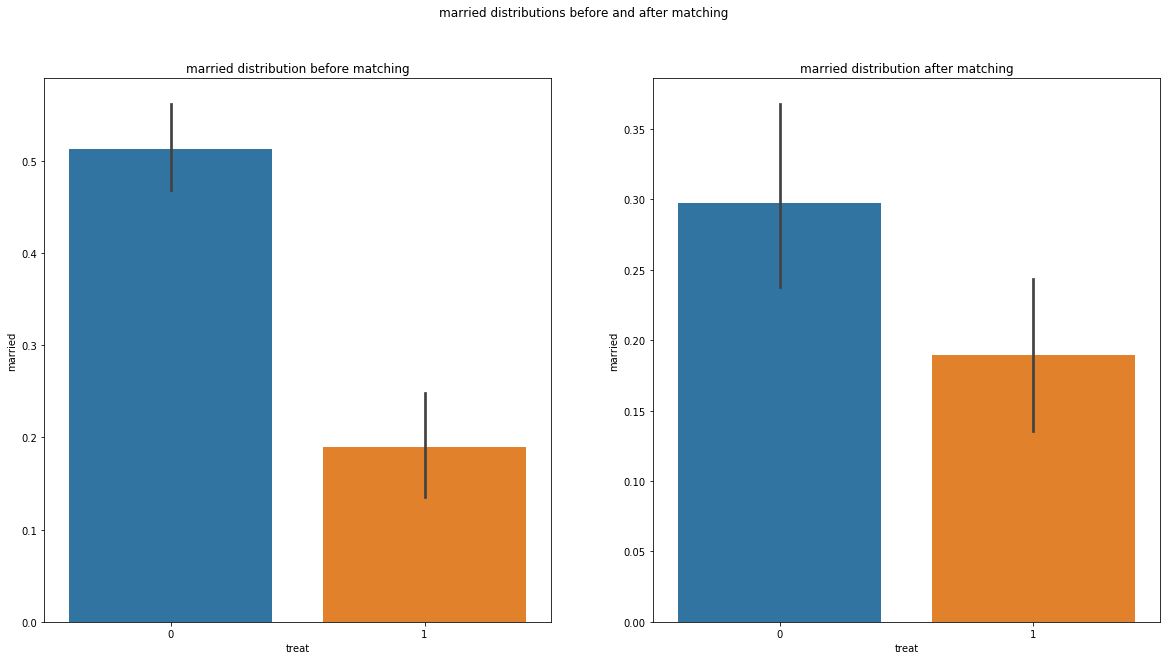

In [107]:
compare_distributions("married")

Better than before ! But still could be much better...

re74 distributions after matching:

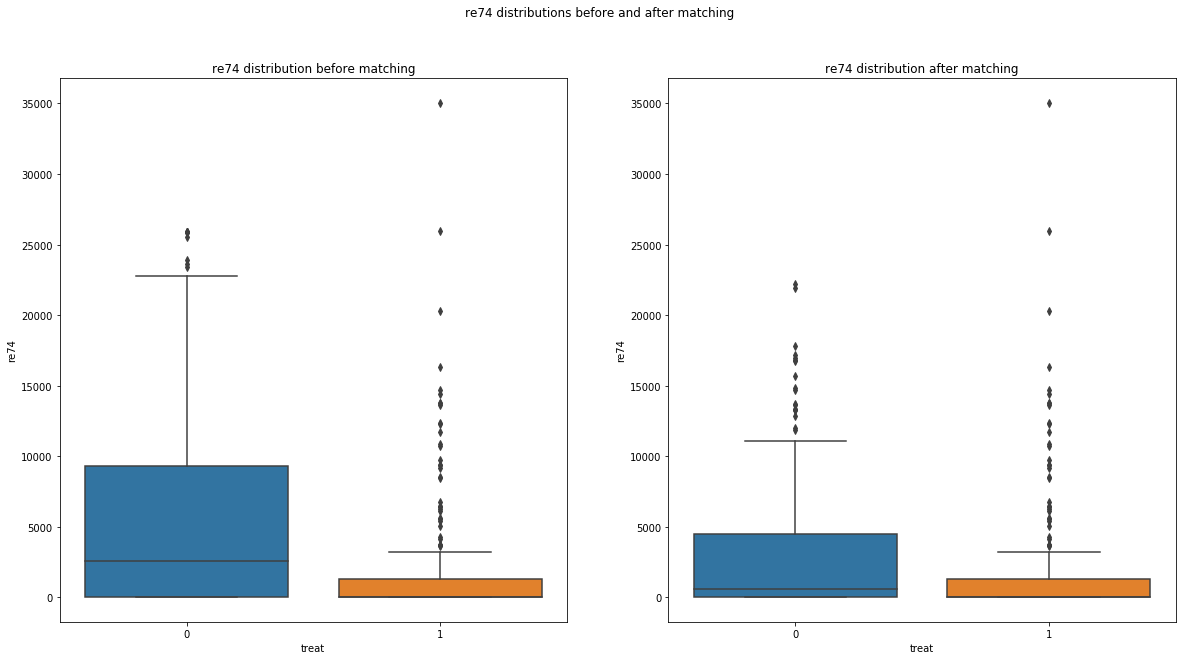

In [108]:
compare_distributions("re74")

The distribution is better in the sense that the treat == 0 distribution got closer to the treat == 1 one. But still, they are different.

re75 distributions after matching:

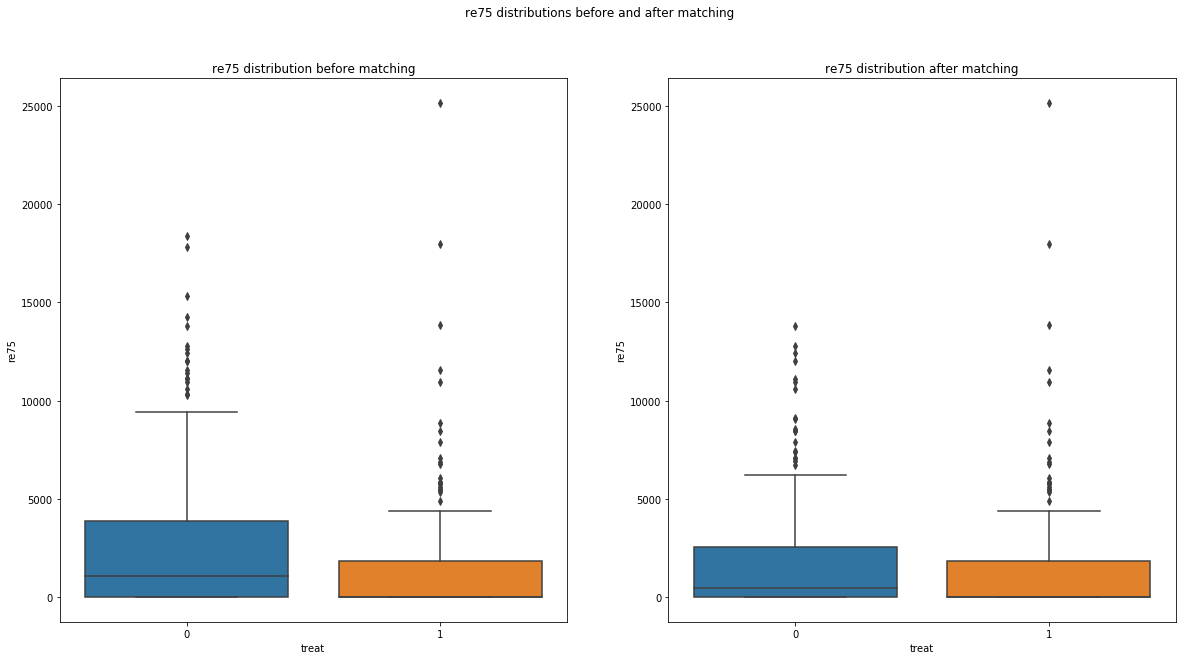

In [109]:
compare_distributions("re75")

We are in better shape here than for re74 (even if the treat == 0 is still more widespread than the treat == 1 distribution)

race distributions after matching:

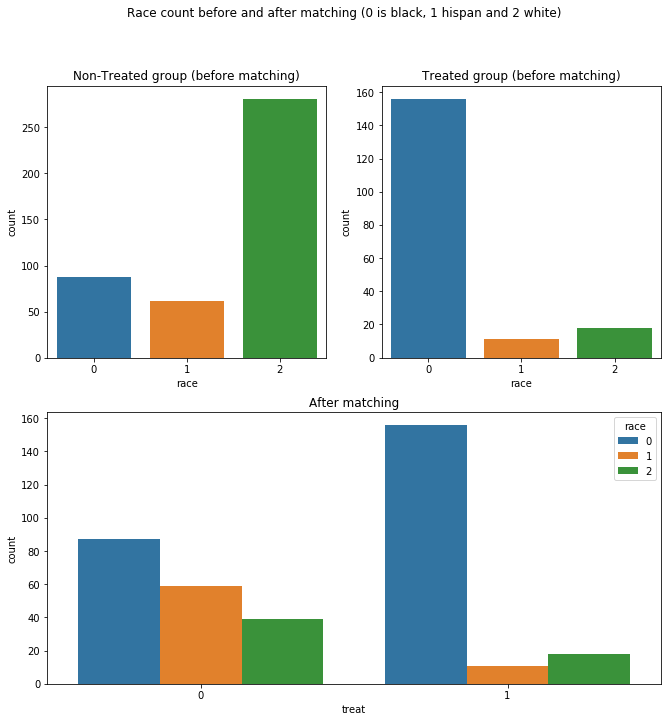

In [110]:
# plot it
fig = plt.figure(figsize=(11, 11))

plt.suptitle("Race count before and after matching (0 is black, 1 hispan and 2 white)")

ax0 = plt.subplot2grid((2, 2), (0, 0))
ax0.set_title("Non-Treated group (before matching)")
sns.countplot(x="race", data=lalonde_notreat, ax=ax0)

ax1 = plt.subplot2grid((2, 2), (0, 1))
ax1.set_title("Treated group (before matching)")
sns.countplot(x="race", data=lalonde_treat, ax=ax1)

ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax2.set_title("After matching")
sns.countplot(x="treat", hue="race", data=lalonde_matched, ax=ax2)
plt.show()

This one seems to be quite problematic even after the matching ! We don't see much improvement except maybe for the race == 2 (white) case. It could be a good idea to force this feature to be the same in our matching !

## 6

In general we see that features distribution has improved for most features but there are some where we still have problems: the race feature seems to be the most problematic one. Now the solution is to choose a feature and to force the matched items to have the same value for that feature.

In [111]:
def matching_feature_fixed(feature, show_plots=True):
    if feature != None:
        matching_feature_fixed = {k:v for k, v in matching_propensity_max_card.items() if lalonde.loc[k][feature] == lalonde.loc[v][feature]}
    else:
        matching_feature_fixed = matching_propensity_max_card
    group_treat = [a for (a, b) in matching_feature_fixed.items()]
    group_no_treat = [b for (a, b) in matching_feature_fixed.items()]
    feature_fixed_treat = lalonde.loc[group_treat]
    feature_fixed_no_treat = lalonde.loc[group_no_treat]
    if show_plots:
        compare_hist("re78", "re78 distribution after forcing matching on {}".format(feature), no_treat_df=feature_fixed_no_treat, treat_df=feature_fixed_treat)
        compare_distributions("re78", action="forcing " + feature, data1=lalonde_matched, data2=pd.concat([feature_fixed_treat, feature_fixed_no_treat]))
        #sns.boxplot(x="treat", y="re78", data=pd.concat([feature_fixed_treat, feature_fixed_no_treat]))
    return feature_fixed_treat, feature_fixed_no_treat

### Race feature fixed:

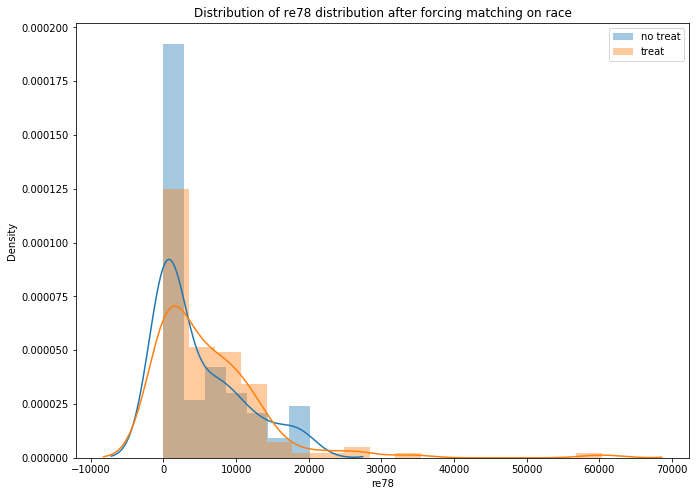

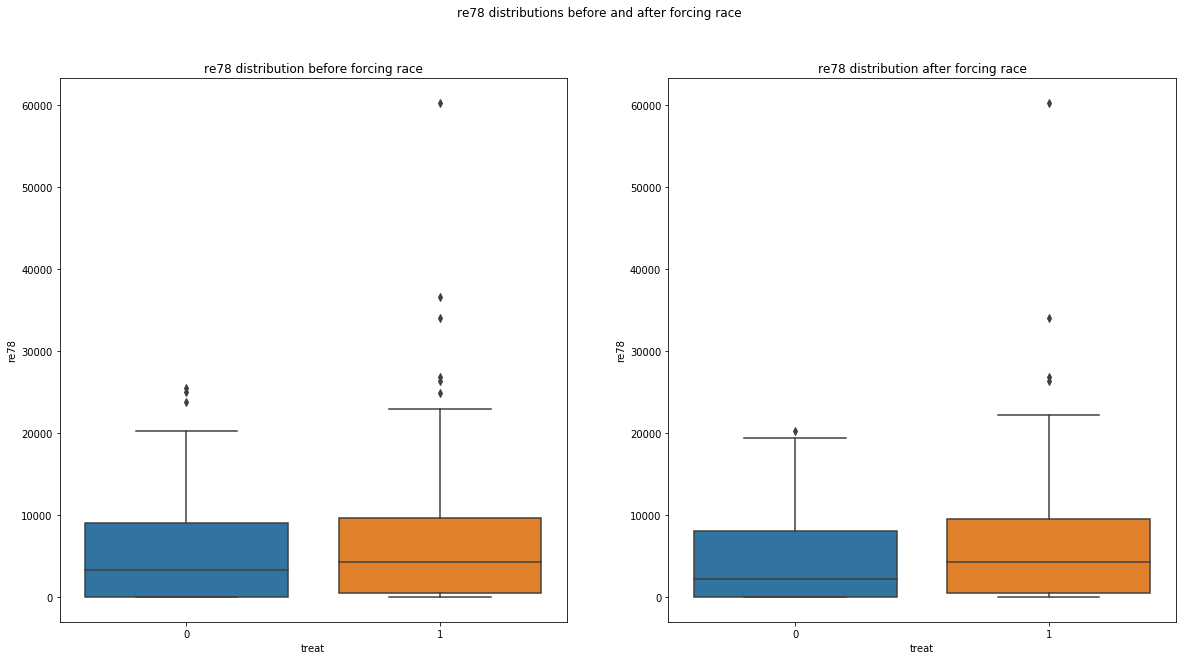

In [112]:
race_fixed_treat, race_fixed_no_treat = matching_feature_fixed("race")

Now the results are much clearer if we force the race to be the same: the treat group is clearly above the no-treat  group !

Just to convince you that the race distribution is the same:

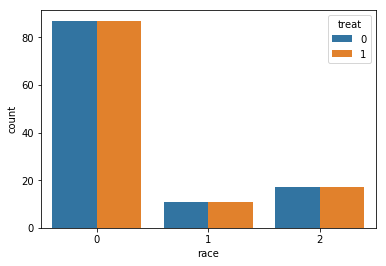

In [113]:
sns.countplot(x="race", hue="treat", data=pd.concat([race_fixed_no_treat, race_fixed_treat]))

### Age feature fixed

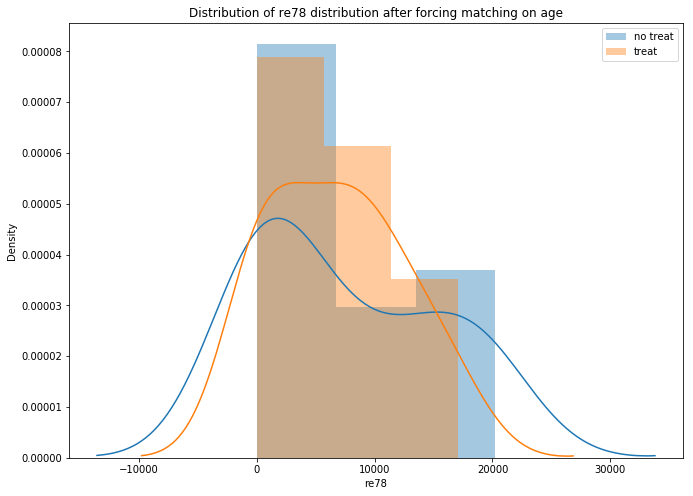

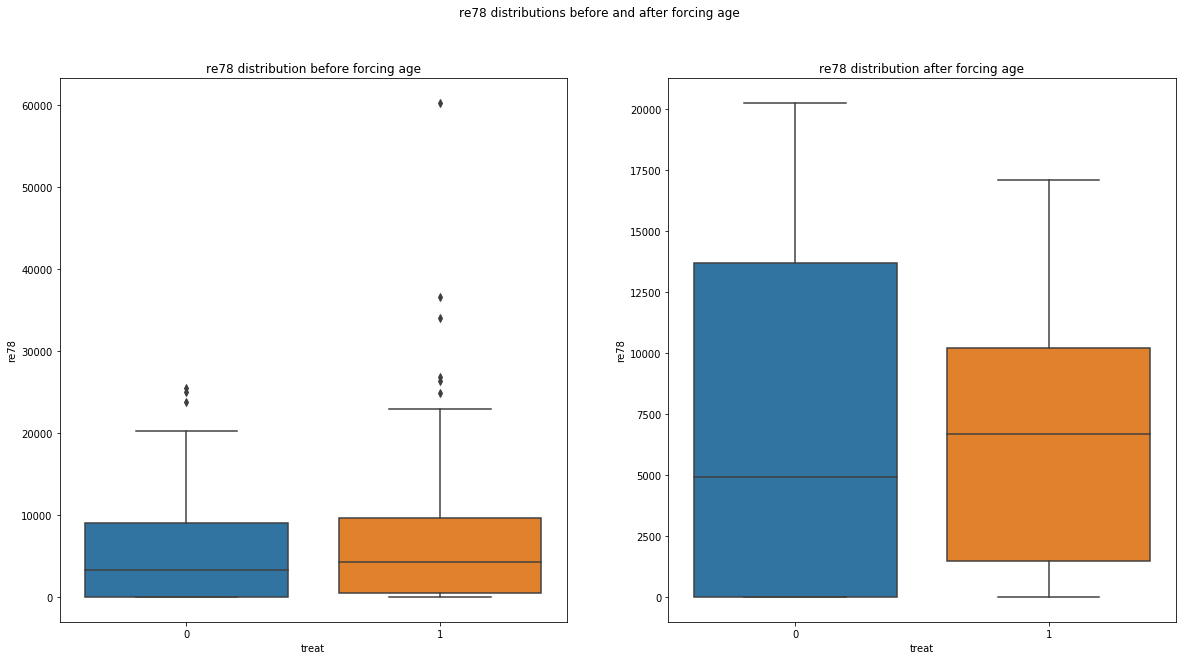

In [114]:
age_fixed_treat, age_fixed_no_treat = matching_feature_fixed("age")

However, if we try to force the age distribution we see that the salary doesn't get better after the treat.

### married

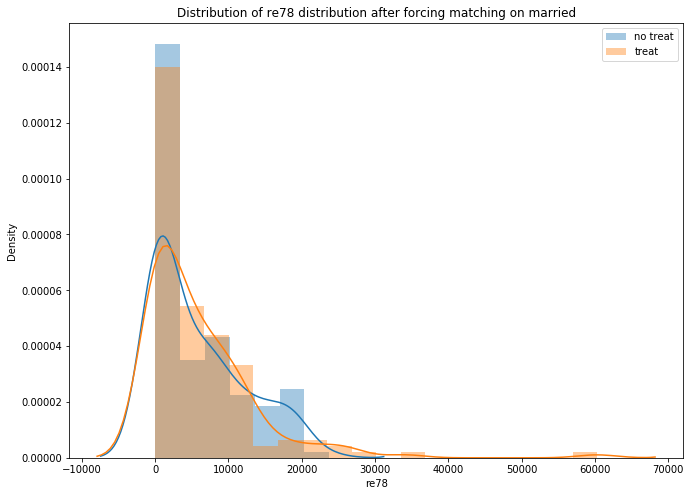

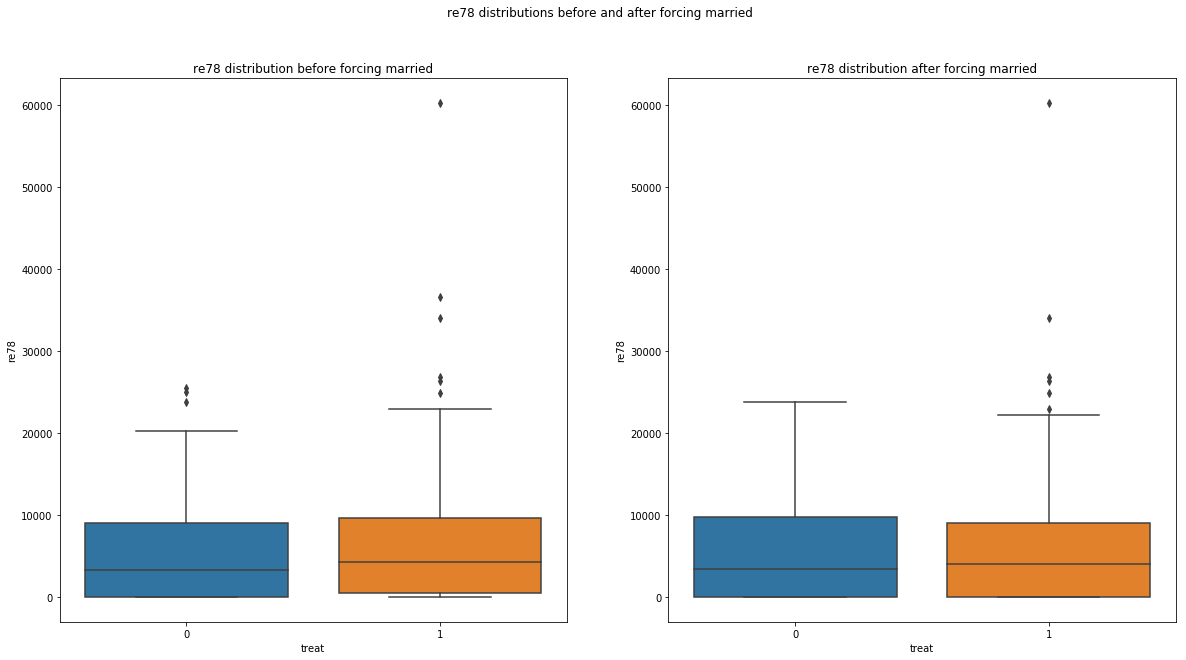

In [115]:
married_fixed_treat, married_fixed_no_treat = matching_feature_fixed("married")

The distribution doesn't really change a lot from the simple matching case.

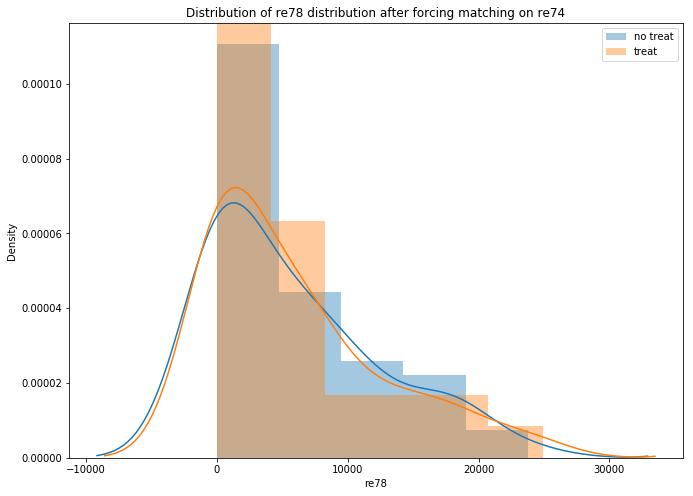

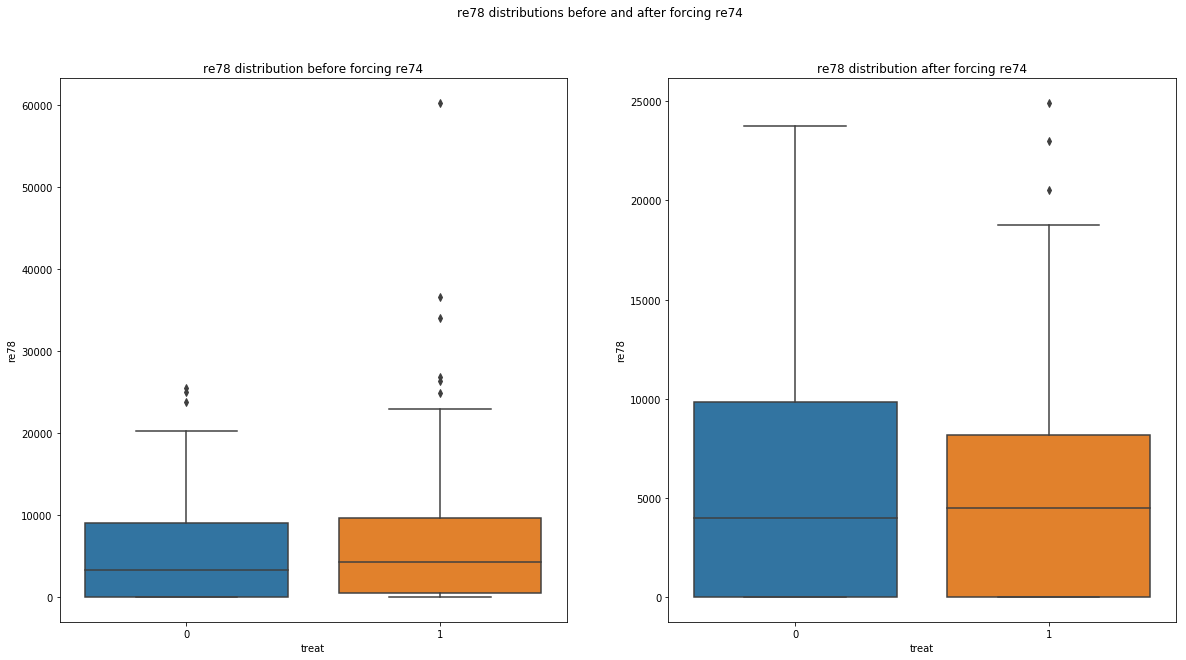

In [116]:
re74_fixed_treat, re74_fixed_no_treat = matching_feature_fixed("re74")

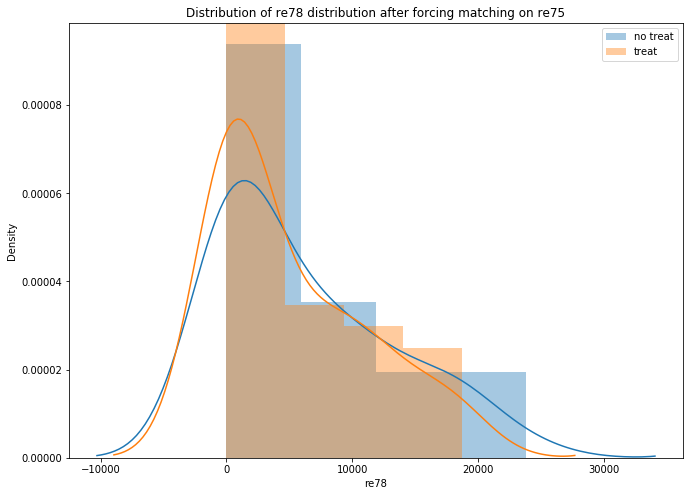

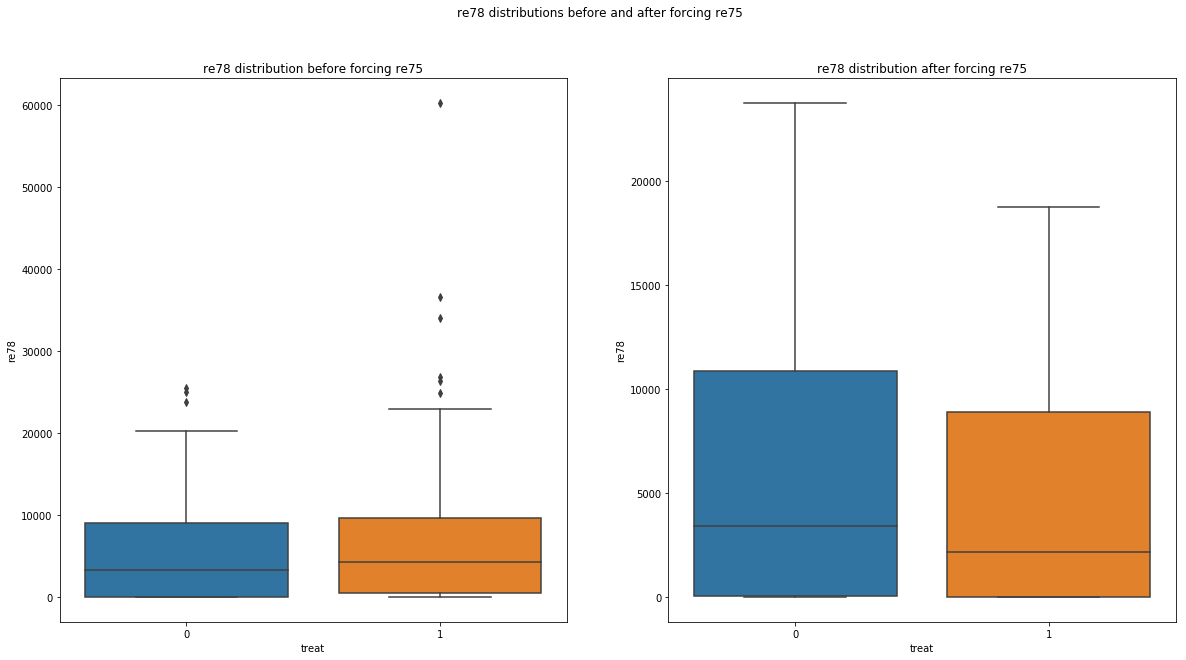

In [117]:
re74_fixed_treat, re74_fixed_no_treat = matching_feature_fixed("re75")

We see that by forcing the re74-75 features (pre-treatment incomes) the non-treated group has, on average, a higher outcome !

### Conclusion

It is difficult to draw some precise conclusions about this treatment program. If we force the matchings on people of the same race then we get better incomes so we can somehow conclude that, based on the race criterion, having followed this program gives better income. However, it is not the same if we force the other features to be the same. Maybe a further step we might do would be to force more than one feature to be the same but the problem is that we will end up with too few matchings.

## Question 2: Applied ML


## Loading the data
First we load the data and vectorize it.
The library functions contained in sklearn make this very straightforward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# we use the builtin function for loading data
# sklearn already has a split in train/test, you can specify which data you want with the "subset" parameter
# since we will perform that split ourselves, we load all data
# we do not remove any metadata, this leads to much worse classification results

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset="all")

In [3]:
# the newsgroups are an sklearn "bunch"
# it resembles a dictionary
newsgroups.keys()

dict_keys(['description', 'DESCR', 'filenames', 'target_names', 'target', 'data'])

In [4]:
# data contains the text for each article
newsgroups.data[0]

"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [5]:
# check how many articles we have
len(newsgroups.data)

18846

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# this will create a vector for every article
# the output is a matrix
# please note that we use a specific parametrization for the vectorizer:
# we exclude words that are too frequent, they are not specific enough to identify correlations with categories
# we also apply a smoothing operation
matrix = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english').fit_transform(newsgroups.data)

print(type(matrix))
print(matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(18846, 173446)


## Splitting the data

We split the data into separate sets for training, testing and evaluating.
Following the usual naming convention in machine learning, we call these datasets

 - X_train, y_train
 - X_test, y_test
 - X_val, y_val
 
where X is the data and y contains the labels

In [7]:
# renaming
X = matrix
y = newsgroups.target

In [8]:
# now we do the split into train, test, val
# it's 0.8, 0.1, 0.1

num_samples = len(y)
num_train = int(0.8 * num_samples)
num_test = int(0.1 * num_samples)
num_val = int(0.1 * num_samples)

X_train = X[:num_train]
X_test = X[num_train : -num_val]
X_val = X[-num_val:]


y_train = y[:num_train]
y_test = y[num_train : -num_val]
y_val = y[-num_val:]

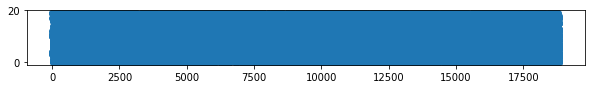

In [9]:
# we know whether the data is ordered
# it would be possible that we have all articles from category 1 first, then category 2, etc
# this would mean that our split is broken
# we take a look at the labels
# the scatterplot shows that there is no order, the labels don't increase linearly
plt.figure(figsize=(10,1))
plt.scatter(np.arange(len(y)), y)
plt.show()

## Searching for optimal parameters

### Fitting a RandomForest

Before we start the grid search, we fit a random forest, to see how the syntax looks.

We also want to check whether the classifier actually works, or if we have made some mistake. There are 20 categories. If the classifier is just guessing randomly, we would see an accuracy of about 1/20 = 5%. If the classifier does better than that, it is able to "learn" the data. That would mean we can continue to search for a good parametrization.

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
# use the classifier to predict labels for the test set
random_forest.score(X_test, y_test)

0.74549310710498407

The accuracy is already rather good. And this is for top-1 results. It would probably do much better if we would compute something like the top-2 or top-3 accuracy.

The number of estimators is 10 by default. I would like to get the max depth that was used in this tree. Then we can use these parameters as the center of our grid search.

In [12]:
# unfortunately, we are apparently not supposed to read the depth
# it is necessary to use properties with _ in their name
depths = [estimator.tree_.max_depth for estimator in random_forest.estimators_]


max_depth = max(depths)
avg_depth = sum(depths)/len(depths)

print("max depth is: ", max_depth)
print("avg depth is: ", avg_depth)

max depth is:  560
avg depth is:  451.9


### Gridsearch, 1st approach

We use the parameters given above to set up our gridsearch.

In [13]:
n_estimators = np.arange(10) + 5
max_depths = 7 * np.logspace(1, 2, num=5, dtype=np.int)

print("num estimators: ", n_estimators)
print("max depths: ", max_depths)

# we will use multithreading to process the grid on multiple cpus
# the load balancing of sklearn is not very complex
# it just splits the list and then collects the results
# but the parametrizations for more estimators / depths take much longer
# so we shuffle, as a simple load balancing
np.random.shuffle(n_estimators)
np.random.shuffle(max_depths)

num estimators:  [ 5  6  7  8  9 10 11 12 13 14]
max depths:  [ 70 119 217 392 700]


In [14]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.sparse import vstack

In [15]:
train_indices = [-1] * X_train.shape[0]
test_indices = [0] * X_test.shape[0]
indices = train_indices + test_indices

X_joint = vstack([X_train, X_test])
y_joint = np.concatenate([y_train, y_test])

pds = PredefinedSplit(indices)

### Loading saved states
Computing the grid searches takes a long time. We ended up doing 3 grid searches, and the third one takes many hours.
Therefore we use pickle to save the results to disk. We can load them instead of having to recompute them every time.

In [16]:
import pickle
rerun = False

In [17]:
if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid1 = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators, 'max_depth':max_depths}, cv=pds, n_jobs=-1)
    clf_grid1.fit(X_joint, y_joint)
    
    with open("data/clf_grid.pickle", "wb") as file:
        pickle.dump(clf_grid1, file)
else:
    with open("data/clf_grid.pickle", "rb") as file:
        clf_grid1 = pickle.load(file)

### Discussing results, for 1st GridSearch

The results on both the training and the test set are very good. We reach well above 90%.

But checking against the validation set shows that the results are not generalizable. We are not only overfitting the training data, the cross-validation of the parameters also resulted in training against the test set. We do note an improvement compared to the first evaluation, though.

The overfitting on the test set is so strong that we need to question whether our split is actually working. But it seems to be set up correctly.

In [18]:
# on the train and test set, our classifier performs very well
print("train score: ", clf_grid1.score(X_train, y_train))
print("test score: ", clf_grid1.score(X_test, y_test))

train score:  0.999469355267
test score:  0.999469777306


In [19]:
# but on the val set, we perform badly
print("test score: ", clf_grid1.score(X_val, y_val))

test score:  0.792993630573


In [20]:
# looking at the predefined splot
# it generates 1 set of train/test, that is good
print("the split generates {} splits into train and test set".format(pds.get_n_splits()))

# let's check the indices
# they also look good
train, test = next(pds.split())
print("the training indices go from {} to {}".format(train.min(), train.max()))
print("the testing indices go from {} to {}".format(test.min(), test.max()))

the split generates 1 splits into train and test set
the training indices go from 0 to 15075
the testing indices go from 15076 to 16961


### Gridsearch, 2nd approach
Our gridsearch is strongly overfitting.

Overfitting is usually due to too high model complexity. So we start a second gridsearch with reduced complexity.

In [21]:
n_estimators2 = n_estimators = np.arange(10) + 5
max_depths2 = 2 * np.logspace(1, 2, num=5, dtype=np.int)


print("num estimators: ", n_estimators2)
print("max depths: ", max_depths2)

np.random.shuffle(n_estimators2)
np.random.shuffle(max_depths2)

num estimators:  [ 5  6  7  8  9 10 11 12 13 14]
max depths:  [ 20  34  62 112 200]


In [22]:
if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid2 = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators2, 'max_depth':max_depths2}, cv=pds, n_jobs=-1)
    clf_grid2.fit(X_joint, y_joint)
    
    with open("data/clf_grid2.pickle", "wb") as file:
        pickle.dump(clf_grid2, file)
else:
    with open("data/clf_grid2.pickle", "rb") as file:
        clf_grid2 = pickle.load(file)

### Discussing results for the 2nd gridsearch

The performance is very similar to the first gridsearch

In [23]:
# on the train and test set, our classifier performs very well
print("train score: ", clf_grid2.score(X_train, y_train))
print("test score: ", clf_grid2.score(X_test, y_test))

train score:  0.992305651366
test score:  0.991516436903


In [24]:
# but on the val set, we perform badly
print("test score: ", clf_grid2.score(X_val, y_val))

test score:  0.781847133758


### Revisiting the baseline
Between the first and second gridsearch, we changed the maximum depth. Which had only very little effect on the performance.

We could also change the number of estimators, but this has a strong effect on the complexity and increases the time for training drastically.

Therefore, we do a simple check first: We train just one random forest, with a higher number of estimators and evaluate its performance.

In [25]:
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
rf2.score(X_train, y_train)

0.99993366940833117

In [27]:
rf2.score(X_test, y_test)

0.85949098621420994

In [28]:
depths = [estimator.tree_.max_depth for estimator in rf2.estimators_]


max_depth = max(depths)
avg_depth = sum(depths)/len(depths)

print("max depth is: ", max_depth)
print("avg depth is: ", avg_depth)

max depth is:  545
avg depth is:  431.72


### Gridsearch for the 3rd time

Increasing the number of estimators improves both the training and the validation accuracy.
So we need to perform a gridsearch for higher amounts of estimators.
This will need a lot of time.
We set the gridsearch up to sample many configurations and let it run over night.

In [29]:
n_estimators3 = (40 * np.logspace(0, 1.5, num=20)).astype(np.int)
max_depths3 = 250 + (np.arange(10)*50)

print("num estimators: ", n_estimators3)
print("max depths: ", max_depths3)

np.random.shuffle(n_estimators3)
np.random.shuffle(max_depths3)

num estimators:  [  40   47   57   69   82   99  119  142  171  205  246  295  354  424  509
  611  733  879 1054 1264]
max depths:  [250 300 350 400 450 500 550 600 650 700]


In [30]:
if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid3 = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators3, 'max_depth':max_depths3}, cv=pds, n_jobs=-1)
    clf_grid3.fit(X_joint, y_joint)
    
    with open("data/clf_grid3.pickle", "wb") as file:
        pickle.dump(clf_grid3, file)
else:
    with open("data/clf_grid3.pickle", "rb") as file:
        clf_grid3 = pickle.load(file)

### Discussing results for the 3rd gridsearch

We are reaching almost 90% accuracy on the validation set now. I think this is an acceptable result.

In [31]:
# on the train and test set, our classifier performs very well
print("train score: ", clf_grid3.score(X_train, y_train))
print("test score: ", clf_grid3.score(X_test, y_test))

train score:  0.999933669408
test score:  1.0


In [32]:
# but on the val set, we perform badly
print("test score: ", clf_grid3.score(X_val, y_val))

test score:  0.892781316348


## Confusion matrix
We use the third grid search to plot a confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(clf_grid3.predict(X_val), y_val)

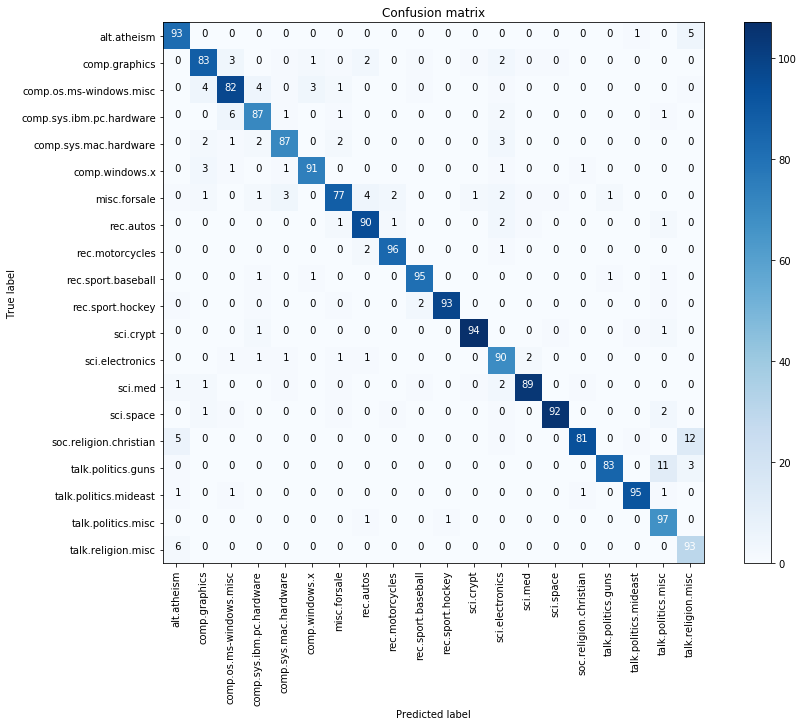

In [34]:
plt.figure(figsize=(13,10))

# plot the background colors
plt.title("Confusion matrix")
plt.imshow(cm, interpolation="None", cmap=plt.cm.Blues)
plt.colorbar()

# plot the category names
target_names = newsgroups.target_names
name_anchors = np.arange(len(target_names))
plt.xticks(name_anchors, target_names, rotation=90)
plt.yticks(name_anchors, target_names)

# normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion percentages, as text
# we need to change the text color based on the background color
# if the background is above a threshold, we use white as text color
thresh = cm.max() / 2.
for i in range(len(target_names)):
    for j in range(len(target_names)): 
        plt.text(j, i, "{:2d}".format(int(cm[i, j]*100)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

## Discussing results

We have reached a validation accuracy of about 89%. This is accuracy, so it only takes the top result into consideration. In one of the comments above, we already mentioned that the model would probably do much better if it could also look at the top-2 or top-3 evaluations. The confusion matrix allows us to revisit this claim.
 - alt.atheism has a 93% accuracy, it is mostly confused with religion.misc. These topics are arguably very close.
 - soc.religion.christian is mostly confused with talk.religion.misc. Again, the topics are semantically close
 - talk.politics.guns is closest to talk.politics.misc
 
It is evident that the classifier is able to learn common structures in certain articles and topics. The classifier could be used to cluster topics by similarity.

We would also like to point out some decisions in setting up the classifier. In a first approach, we only used the content of the article and removed meta information. This leads to much worse results on both training and validation. We also decided to remove features that are too common in the vectorization. Words that occur frequently in every category are probably just common phrases in the language in general and not useful for article classification. A third choice was to apply a smoothing operation in the vectorization, this corresponds to the parameter _sublinear_tf_. Machine learning is very much an empirical approach to classification. We investigated the various combinations and this specific choice led to the best results. The framework of consecutive gridsearches, etc stayed the same during the review of different data preprocessing routines.

# This is the end...

You've made it to the end ? Congrats, and thanks for your review ^_^

> I'm for truth, no matter who tells it. I'm for justice, no matter who it's for or against.

> *Malcolm X*